In [5]:
train_positive =  open("/data1/home/mukeshram/Natural_Language_Processing/Sentiment_analysis/dataset/Train.pos" , "r", encoding="latin-1").read()
train_negative =  open("/data1/home/mukeshram/Natural_Language_Processing/Sentiment_analysis/dataset/Train.neg" , "r", encoding="latin-1").read()
test_data =  open("/data1/home/mukeshram/Natural_Language_Processing/Sentiment_analysis/dataset/TestData" , "r", encoding="latin-1").read()

In [6]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [7]:
def clean(data):
    cleaned_data = []

    for i in data:
        i = i.lower()
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        i = pattern.sub('', i)
        i = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", i)
        tokens = word_tokenize(i)
        stop_words = set(stopwords.words("english"))
        stop_words.discard("not")
        words = [w for w in tokens if w.isalpha() and w not in stop_words]
        words = ' '.join(words)
        cleaned_data.append(words)
    return cleaned_data

In [8]:
train_pos = clean(train_positive.split("\n")[:-1])
train_neg = clean(train_negative.split("\n")[:-1])
test = clean(test_data.split("\n")[:-1])

In [9]:
train_neg[0]

'simplistic silly tedious'

In [10]:
x_train_p = [i +"1" for i in train_pos]
x_train_n = [i +"0" for i in train_neg]
x_data = x_train_p + x_train_n


import random
random.seed(42)
random.shuffle(x_data)


In [11]:
x_data[0:5]

['questioning election process payami graphically illustrates problems fledgling democracies also strength sense freedom iranian people already possess without access ballot box1',
 'bright side contains jesse ventura best work since xfl0',
 'acting particularly tambor almost makes never worthwhile writerdirector schaeffer follow titular advice0',
 'andersson creates world surreal disturbingly familiar absurd yet tremendously sad1',
 'always appreciated smartly written motion picture whatever flaws igby goes may possess undeniably1']

In [12]:
x_train_data = [i[:-1] for i in x_data]
y_train = [int(i[-1]) for i in x_data]

In [13]:
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load("/data1/home/mukeshram/NLP/word2vec_google_news_model")

In [14]:
from gensim.models import KeyedVectors
glove_model = KeyedVectors.load("/data1/home/mukeshram/NLP/glove-wiki-gigaword-300")

In [15]:
len(word2vec_model["king"]),len(glove_model["king"])



(300, 300)

In [16]:
import numpy as np

def sentence_embedding(sentence, word2vec_model, glove_model):
    words = sentence.split()
    sentence_vector_w2v = np.zeros(word2vec_model.vector_size)
    sentence_vector_glove = np.zeros(glove_model.vector_size)
    
    for word in words:
        if word in word2vec_model:
            sentence_vector_w2v += word2vec_model[word]
        
        if word in glove_model:
            sentence_vector_glove += glove_model[word]
    
    num_words = len(words)
    if num_words > 0:
        sentence_vector_w2v /= num_words
        sentence_vector_glove /= num_words
    
    sentence_vector = np.concatenate((sentence_vector_w2v, sentence_vector_glove))
    return sentence_vector



In [17]:
len(sentence_embedding("king", word2vec_model, glove_model))

600

In [18]:
x_train=[]
for i in x_train_data:
    x_train.append(sentence_embedding(i, word2vec_model, glove_model))
    
    

In [19]:
len(x_train)

10000

In [20]:
y_train[0]


1

In [21]:
x_test=[]
for i in test:
    x_test.append(sentence_embedding(i, word2vec_model, glove_model))


In [22]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)

In [23]:
x_train.shape, y_train.shape

((10000, 600), (10000,))

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [25]:
from sklearn.model_selection import cross_validate, train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, shuffle=False)


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [27]:
model = keras.Sequential([
    layers.Input(shape=(600,)),  # Input layer
    # layers.Dense(600, activation='relu'),  # Hidden layer(s)
    layers.Dense(1200, activation='relu'),  # Hidden layer(s)
    layers.Dense(600, activation='relu'),  # Hidden layer(s)
    layers.Dense(300, activation='relu'),  # Hidden layer(s)

    layers.Dense(100, activation='relu'),  # Hidden layer(s)

    layers.Dense(1, activation='sigmoid')  # Output layer
])


In [28]:
learning_rate = 0.001  # You can adjust this value
optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1200)              721200    
                                                                 
 dense_2 (Dense)             (None, 600)               720600    
                                                                 
 dense_3 (Dense)             (None, 300)               180300    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1652301 (6.30 MB)
Trainable params: 1652301 (6.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [26]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    # batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stopping],  # Use the early stopping callback
                    verbose=1)


Epoch 1/100
200/200 [==============================] - 6s 22ms/step - loss: 0.6525 - accuracy: 0.6231 - val_loss: 0.6083 - val_accuracy: 0.6944
Epoch 2/100
200/200 [==============================] - 4s 19ms/step - loss: 0.5659 - accuracy: 0.7302 - val_loss: 0.5558 - val_accuracy: 0.7256
Epoch 3/100
200/200 [==============================] - 4s 18ms/step - loss: 0.5133 - accuracy: 0.7577 - val_loss: 0.5346 - val_accuracy: 0.7331
Epoch 4/100
200/200 [==============================] - 4s 18ms/step - loss: 0.4833 - accuracy: 0.7698 - val_loss: 0.5243 - val_accuracy: 0.7431
Epoch 5/100
200/200 [==============================] - 3s 17ms/step - loss: 0.4623 - accuracy: 0.7809 - val_loss: 0.5174 - val_accuracy: 0.7525
Epoch 6/100
200/200 [==============================] - 3s 17ms/step - loss: 0.4451 - accuracy: 0.7897 - val_loss: 0.5143 - val_accuracy: 0.7544
Epoch 7/100
200/200 [==============================] - 4s 18ms/step - loss: 0.4296 - accuracy: 0.7991 - val_loss: 0.5132 - val_accuracy:

63/63 [==============================] - 1s 6ms/step - loss: 0.5202 - accuracy: 0.7425
Test accuracy: 0.7425000071525574


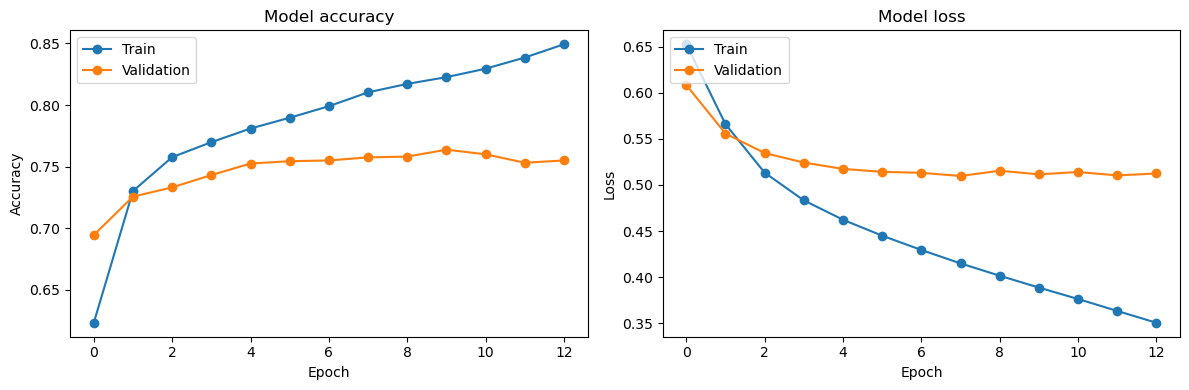

In [27]:
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],marker = 'o')
plt.plot(history.history['val_accuracy'],marker = 'o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],marker = 'o')
plt.plot(history.history['val_loss'],marker = 'o')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

63/63 [==============================] - 0s 6ms/step - loss: 0.5202 - accuracy: 0.7425
Test accuracy: 0.7425000071525574


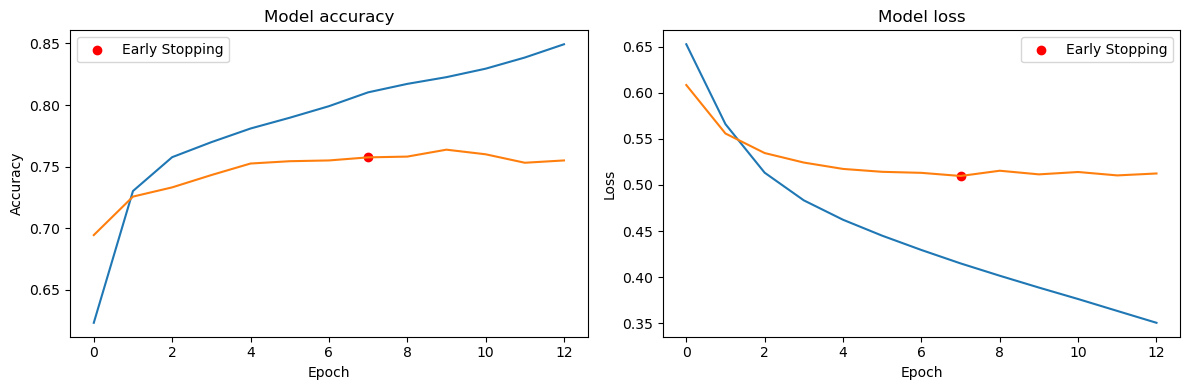

In [28]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Indicate the point where early stopping occurred
best_val_loss_index = np.argmin(history.history['val_loss'])
plt.scatter(best_val_loss_index, history.history['val_accuracy'][best_val_loss_index], color='red', marker='o', label='Early Stopping')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Indicate the point where early stopping occurred
plt.scatter(best_val_loss_index, history.history['val_loss'][best_val_loss_index], color='red', marker='o', label='Early Stopping')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming you have prepared your feature matrix X and target vector y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.74


/data1/home/mukeshram/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming you have prepared your feature matrix X and target vector y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM model
model = SVC(kernel='linear')  # You can choose different kernels like 'linear', 'rbf', 'poly', etc.

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.73


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming you have prepared your feature matrix X and target vector y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create SVM models with different kernels
linear_model = SVC(kernel='linear')
rbf_model = SVC(kernel='rbf')
poly_model = SVC(kernel='poly', degree=3)  # You can adjust the degree parameter

# Train the models on the training data
linear_model.fit(X_train, y_train)
rbf_model.fit(X_train, y_train)
poly_model.fit(X_train, y_train)

# Make predictions on the test data
linear_predictions = linear_model.predict(X_test)
rbf_predictions = rbf_model.predict(X_test)
poly_predictions = poly_model.predict(X_test)

# Calculate accuracies
linear_accuracy = accuracy_score(y_test, linear_predictions)
rbf_accuracy = accuracy_score(y_test, rbf_predictions)
poly_accuracy = accuracy_score(y_test, poly_predictions)

print(f"Linear Kernel Accuracy: {linear_accuracy:.2f}")
print(f"RBF Kernel Accuracy: {rbf_accuracy:.2f}")
print(f"Poly Kernel Accuracy: {poly_accuracy:.2f}")


Linear Kernel Accuracy: 0.73
RBF Kernel Accuracy: 0.76
Poly Kernel Accuracy: 0.74


In [32]:
import tensorflow as tf

embedding_dim = 600
hidden_units = 128
num_classes = 10  # Replace with your actual number of classes

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(embedding_dim,)),
    tf.keras.layers.Reshape(target_shape=(1, embedding_dim)),
    tf.keras.layers.SimpleRNN(hidden_units),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='Adagrad', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [33]:
history = model.fit(X_train, y_train,
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],  # Use the early stopping callback
                    verbose=1)

Epoch 1/500
200/200 [==============================] - 4s 10ms/step - loss: 2.3015 - accuracy: 0.2228 - val_loss: 2.0552 - val_accuracy: 0.3619
Epoch 2/500
200/200 [==============================] - 1s 6ms/step - loss: 1.8531 - accuracy: 0.4541 - val_loss: 1.8194 - val_accuracy: 0.4931
Epoch 3/500
200/200 [==============================] - 1s 6ms/step - loss: 1.6541 - accuracy: 0.5638 - val_loss: 1.6994 - val_accuracy: 0.5550
Epoch 4/500
200/200 [==============================] - 1s 6ms/step - loss: 1.5379 - accuracy: 0.6173 - val_loss: 1.6235 - val_accuracy: 0.5919
Epoch 5/500
200/200 [==============================] - 1s 6ms/step - loss: 1.4591 - accuracy: 0.6481 - val_loss: 1.5705 - val_accuracy: 0.6169
Epoch 6/500
200/200 [==============================] - 1s 6ms/step - loss: 1.3997 - accuracy: 0.6734 - val_loss: 1.5292 - val_accuracy: 0.6313
Epoch 7/500
200/200 [==============================] - 1s 7ms/step - loss: 1.3523 - accuracy: 0.6902 - val_loss: 1.4950 - val_accuracy: 0.644

63/63 [==============================] - 1s 4ms/step - loss: 0.6083 - accuracy: 0.7490
Test accuracy: 0.7490000128746033


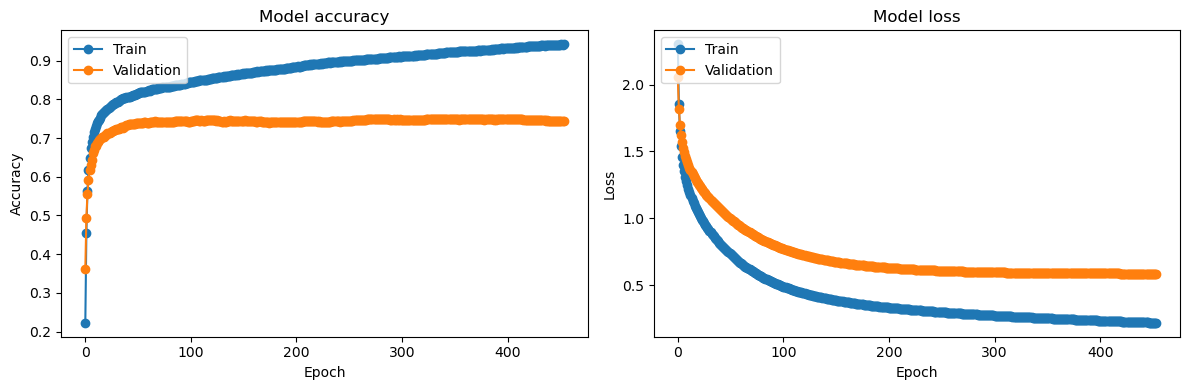

In [34]:
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],marker = 'o')
plt.plot(history.history['val_accuracy'],marker = 'o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],marker = 'o')
plt.plot(history.history['val_loss'],marker = 'o')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
import tensorflow as tf

embedding_dim = 600
hidden_units = 128
num_classes = 10  # Replace with your actual number of classes

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(embedding_dim,)),
    tf.keras.layers.Reshape(target_shape=(1, embedding_dim)),
    tf.keras.layers.LSTM(hidden_units),  # Change SimpleRNN to LSTM
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='Adagrad', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [36]:
history = model.fit(X_train, y_train,
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],  # Use the early stopping callback
                    verbose=1)

Epoch 1/500
200/200 [==============================] - 7s 16ms/step - loss: 2.2691 - accuracy: 0.1514 - val_loss: 2.2017 - val_accuracy: 0.2419
Epoch 2/500
200/200 [==============================] - 2s 9ms/step - loss: 2.1478 - accuracy: 0.3231 - val_loss: 2.0965 - val_accuracy: 0.4025
Epoch 3/500
200/200 [==============================] - 2s 9ms/step - loss: 2.0416 - accuracy: 0.4802 - val_loss: 2.0007 - val_accuracy: 0.5337
Epoch 4/500
200/200 [==============================] - 2s 9ms/step - loss: 1.9431 - accuracy: 0.5916 - val_loss: 1.9108 - val_accuracy: 0.6050
Epoch 5/500
200/200 [==============================] - 2s 9ms/step - loss: 1.8500 - accuracy: 0.6558 - val_loss: 1.8254 - val_accuracy: 0.6531
Epoch 6/500
200/200 [==============================] - 2s 9ms/step - loss: 1.7613 - accuracy: 0.6928 - val_loss: 1.7439 - val_accuracy: 0.6819
Epoch 7/500
200/200 [==============================] - 2s 9ms/step - loss: 1.6768 - accuracy: 0.7155 - val_loss: 1.6663 - val_accuracy: 0.701

63/63 [==============================] - 1s 5ms/step - loss: 0.5406 - accuracy: 0.7490
Test accuracy: 0.7490000128746033


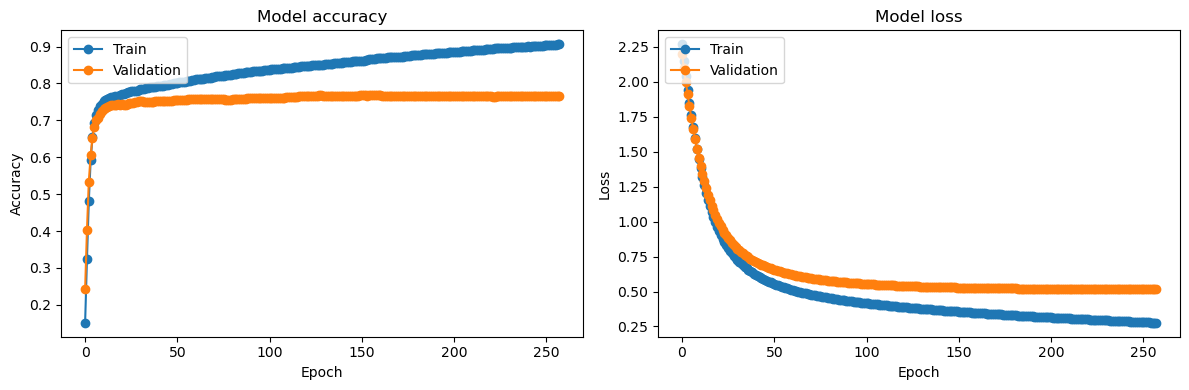

In [37]:
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],marker = 'o')
plt.plot(history.history['val_accuracy'],marker = 'o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],marker = 'o')
plt.plot(history.history['val_loss'],marker = 'o')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [32]:
import tensorflow as tf

embedding_dim = 600
hidden_units = 128
num_classes = 10  # Replace with your actual number of classes

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(embedding_dim,)),
    tf.keras.layers.Reshape(target_shape=(1, embedding_dim)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1200, return_sequences=True)),  # Bidirectional LSTM
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True)),   # Bidirectional LSTM
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),  # Bidirectional LSTM
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='Adagrad', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [33]:
history = model.fit(X_train, y_train,
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],  # Use the early stopping callback
                    verbose=1)

Epoch 1/500
200/200 [==============================] - 22s 85ms/step - loss: 2.1862 - accuracy: 0.2529 - val_loss: 2.0854 - val_accuracy: 0.3957
Epoch 2/500
200/200 [==============================] - 15s 77ms/step - loss: 1.9724 - accuracy: 0.4531 - val_loss: 1.9107 - val_accuracy: 0.4788
Epoch 3/500
200/200 [==============================] - 15s 76ms/step - loss: 1.8001 - accuracy: 0.4919 - val_loss: 1.7683 - val_accuracy: 0.4958
Epoch 4/500
200/200 [==============================] - 15s 75ms/step - loss: 1.6589 - accuracy: 0.4990 - val_loss: 1.6520 - val_accuracy: 0.5003
Epoch 5/500
200/200 [==============================] - 14s 68ms/step - loss: 1.5433 - accuracy: 0.5052 - val_loss: 1.5567 - val_accuracy: 0.5028
Epoch 6/500
200/200 [==============================] - 13s 64ms/step - loss: 1.4477 - accuracy: 0.5064 - val_loss: 1.4775 - val_accuracy: 0.5031
Epoch 7/500
200/200 [==============================] - 13s 64ms/step - loss: 1.3673 - accuracy: 0.5070 - val_loss: 1.4101 - val_ac

63/63 [==============================] - 2s 10ms/step - loss: 0.5367 - accuracy: 0.5078
Test accuracy: 0.5078125


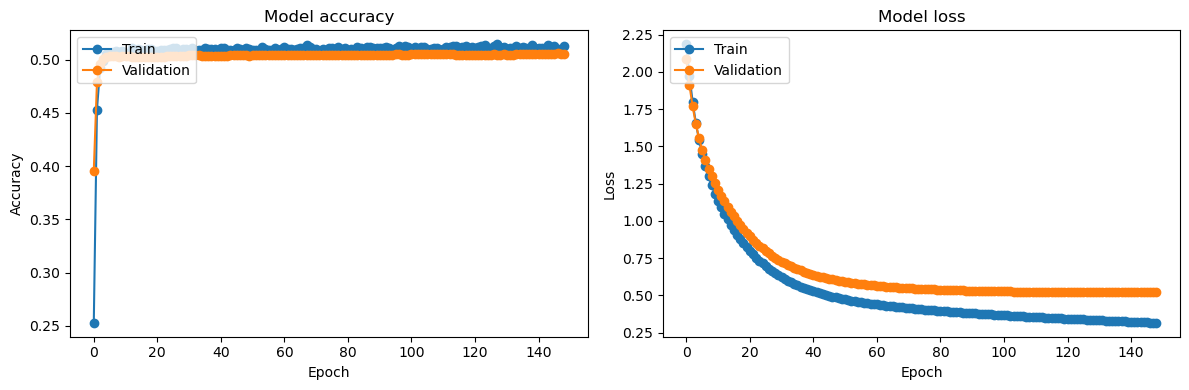

In [34]:
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],marker = 'o')
plt.plot(history.history['val_accuracy'],marker = 'o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],marker = 'o')
plt.plot(history.history['val_loss'],marker = 'o')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()